In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBRegressor

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.rcParams["figure.figsize"] = (8, 6)

root_path = '/content/drive/MyDrive/Colab Notebooks/TheMathCompany-hackathon/'

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PLAN OF ACTION

basic cleaning
- bring data into correct format (remove 'Turbo', km, '-', etc)
- study the relationship of each variable with target (visualise)
- apply log transformation to price

Studying and imputing outliers
- replace the price of outliers by average price of that car in dataset
- replace feature values that are absurdly high, with those of similar cars
- do manual imputation if necessary

feature engineering
- convert prod to 'current year - prod'

target transformation
- take log of price (since we are predicting RMSLE)

encoding and imputing
- mean/median for numeric 
- onehot for categorical

model fitting
- split into train and val randomly (70:30)
- try with tree ensembles (randomforest) and xgb
- log model hyperparams and metrics for each run

test prediction and submission
- load and transform test data
- predict and save for submission

In [ ]:
df = pd.read_csv(root_path+'train.csv')
dfc = df.copy()
df.shape

(19237, 17)

In [ ]:
df.head(2)

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8


In [ ]:
df.isnull().sum().sum()

0

###  Let us take a look at each the features, and do cleaning, wherever needed.

Let us first modify the column names to single-word, lowercase names for convenience.

In [ ]:
# FUNCTION TO DO INITIAL FORMAT CORRECTION AND CLEANING

def carprice_preprocess(df, istest=False):
    
    df = df.drop('ID', axis=1)

    # shortening column names
    for col in df.columns:
      new_col = col.lower().split()[0].replace('.','')
      df[new_col] = df[col]
      df = df.drop(col, axis=1)


    # LEVY COLUMN - replacing '-' with NaN
    df['levy'] = df['levy'].replace('-', np.nan)
    df['levy'] = df['levy'].astype('float16')

    # LEATHER -  converting Yes/No to 1 and 0
    df['leather'] = df['leather'].map({'Yes':1, 'No':0})

    # Engine-TURBO - some engines are 'Turbo'; we are making a separate column to represent this 
    df['turbo'] = df['engine'].apply( lambda x: 0 if x.find('Turbo') == -1 else 1)
    df['engine'] = df['engine'].apply(lambda x: str(x).split()[0])
    df['engine'] = df['engine'].apply(lambda x: round(float(x), 3))

    # MILEAGE - it contains "km", removing this and taking only numeric value
    df['mileage'] = df['mileage'].apply(lambda x: x.split()[0])
    df['mileage'] = df['mileage'].astype(int)

    # DOORS - 2nd character always contains the number of doors
    df['doors'] = df['doors'].apply(lambda x: x[1:2])
    df['doors'] = df['doors'].astype('uint8')

    # WHEEL
    df['wheel'] = df['wheel'].map({'Left wheel':'left', 'Right-hand drive':'right'})
    
    # LOG-TRANSFORM PRICE, as final metric is RMSLE (only for TRAIN)
    
    if istest == False:
        df['price'] = np.log(df['price'])
        
    return df

In [ ]:
df = carprice_preprocess(df)
df.head(3)

,price,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,turbo
0,9.497622,1399.0,LEXUS,RX 450,2010,Jeep,1,Hybrid,3.5,186005,6.0,Automatic,4x4,4,left,Silver,12,0
1,9.718422,1018.0,CHEVROLET,Equinox,2011,Jeep,0,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,left,Black,8,0
2,9.043932,NaN,HONDA,FIT,2006,Hatchback,0,Petrol,1.3,200000,4.0,Variator,Front,4,right,Black,2,0


### Lest us now see relation between target and features

In [ ]:
df.sort_values('price', ascending=False)[:5]

,price,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,turbo
16983,17.085365,NaN,OPEL,Combo,1999,Goods wagon,0,Diesel,1.7,99999,4.0,Manual,Front,2,left,Blue,0,0
8541,13.679629,2068.0,LAMBORGHINI,Urus,2019,Universal,1,Petrol,4.0,2531,8.0,Tiptronic,4x4,4,left,Black,0,0
1225,13.349053,NaN,MERCEDES-BENZ,G 65 AMG 63AMG,2020,Jeep,1,Petrol,6.3,0,8.0,Tiptronic,4x4,4,left,Black,12,1
5008,12.640792,1694.0,PORSCHE,911,2016,Coupe,1,Petrol,4.0,8690,6.0,Automatic,Rear,2,left,Black,12,0
14839,12.604614,NaN,LAND ROVER,Range Rover Vogue,2019,Jeep,1,Diesel,3.0,4500,8.0,Tiptronic,4x4,4,left,Black,12,1


#### Let us drop column number 16983 because its clearly an outlier.

In [ ]:
df = df.drop(16983)
df.shape

(19236, 18)

#### Manufacturer

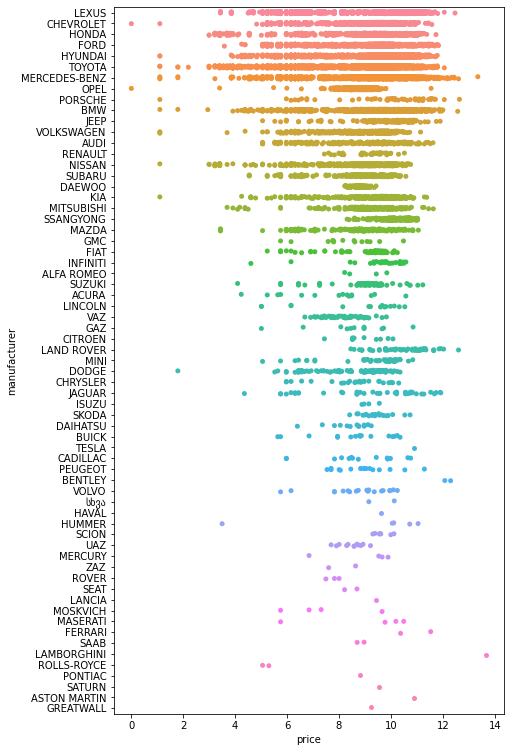

In [ ]:
# MANUFACTURER vs PRICE
plt.figure(figsize=(7,13))
sns.stripplot(data=df, y='manufacturer', x='price');

Manufacturers at the top of the figure (Lexus, Chevrolet, Hyundai, etc.) seem to have cheap as well as costly cars. On the other hand, Ferrari, Lamborghini, Astin-Martin and others (towards the bottom) seem to have mostly expensive cars.

As there are too many different models, it is difficult to show their relatinoship with price visually. We will look at other features.

#### PROD

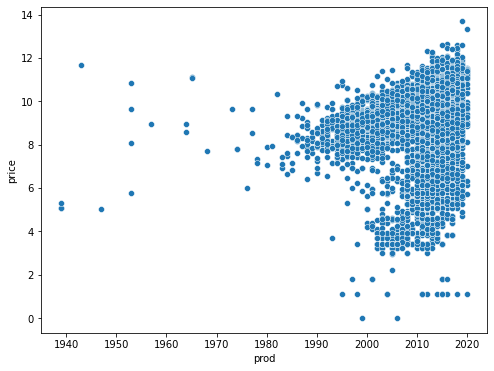

In [ ]:
sns.scatterplot(data=df, x='prod', y='price')

It appears that their is a large variety in the prices of comparatively new cars. Also, most of the cheap cars are relatively new.

#### CATEGORY

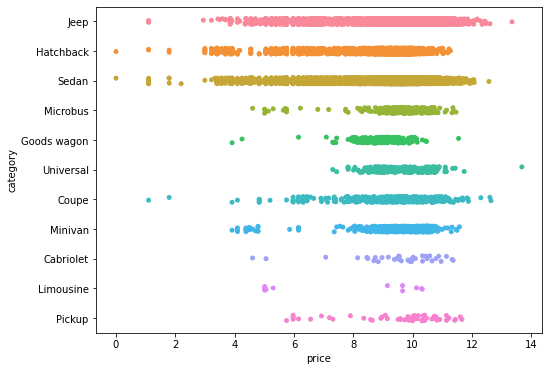

In [ ]:
sns.stripplot(data=df, y='category', x='price')

Minivans, Cabriolets and Pickups seem to costlier in general. There is large variety among Jeeps, Sedans and Hatchbacks, which is expected, because there are very common types of househol cars compared to Limousines and Pickup-trucks.

#### LEATHER

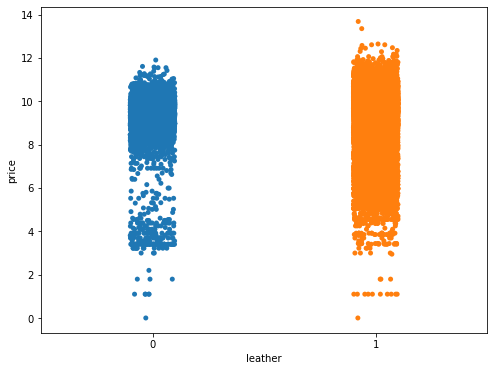

In [ ]:
sns.stripplot(data=df, x='leather', y='price');

There seems to be 2 separate price clusters in cars without leather interiors. Cars with leather interiors are spread across the entire price band.

#### FUEL

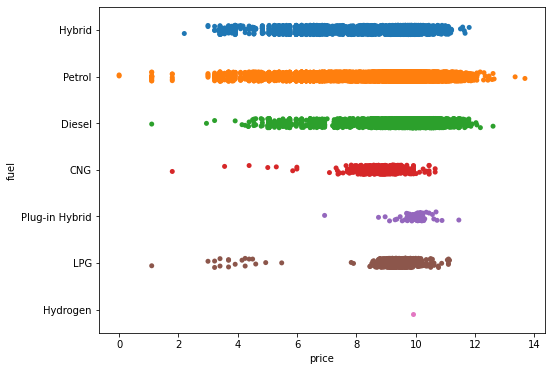

In [ ]:
plt.figure(figsize=(8,6))
sns.stripplot(data=df, y='fuel', x='price')

Petrol, Diesel and Hybrid cars in the dataset are cheaper in general. Plug-in hybrid cars are predominantly expensive.

#### ENGINE

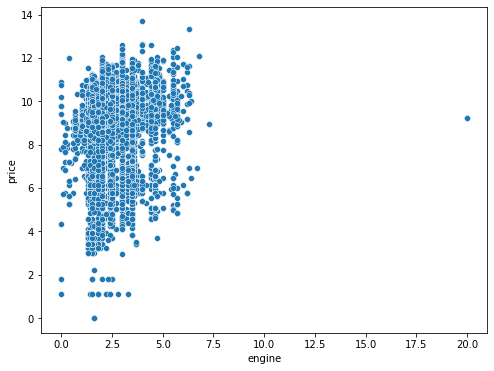

In [ ]:
sns.scatterplot(data=df, x='engine', y='price')

There appears to be cars with 20.0 L engine capacity! Let us investigate.

In [ ]:
df.sort_values('engine', ascending=False)[:4]

,price,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,turbo
17777,9.213934,5604.0,HYUNDAI,Sonata,2014,Sedan,1,LPG,20.0,333686,4.0,Automatic,Front,4,left,Silver,4,0
2357,9.213934,5604.0,HYUNDAI,Sonata,2014,Sedan,1,LPG,20.0,333686,4.0,Automatic,Front,4,left,Silver,4,0
5367,8.966994,5876.0,MERCEDES-BENZ,CLK 430,2005,Cabriolet,0,Petrol,7.3,156470,12.0,Automatic,Rear,4,left,Black,12,0
4722,12.076089,2820.0,BENTLEY,Mulsanne,2016,Sedan,1,Petrol,6.8,6189,8.0,Automatic,Rear,4,left,Black,12,0


20L engine for a Hyundai Sonata sedan of 2014 seems to absurdly high. It has 4 cylinders, so each cyliner will have to be of 500cc capacity, which is insane! Let us take a look at other cars of the same model and production year.

In [ ]:
df.loc[(df['manufacturer'] == 'HYUNDAI')
      & (df['model'] == 'Sonata')
      & (df['prod'] == 2014)
      & (df['leather'] == 1)
      & (df['cylinders'] == 4)
      & (df['turbo'] == 0)
      & (df['gear'] == 'Automatic')
      & (df['fuel'] == 'LPG')
      & (df['color'] == 'Silver')].sort_values('engine', ascending=False)

,price,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,turbo
17777,9.213934,5604.0,HYUNDAI,Sonata,2014,Sedan,1,LPG,20.0,333686,4.0,Automatic,Front,4,left,Silver,4,0
2357,9.213934,5604.0,HYUNDAI,Sonata,2014,Sedan,1,LPG,20.0,333686,4.0,Automatic,Front,4,left,Silver,4,0
12207,9.359105,639.0,HYUNDAI,Sonata,2014,Sedan,1,LPG,2.0,336971,4.0,Automatic,Front,4,left,Silver,4,0
13732,9.213934,639.0,HYUNDAI,Sonata,2014,Sedan,1,LPG,2.0,335782,4.0,Automatic,Front,4,left,Silver,4,0
13396,9.359105,639.0,HYUNDAI,Sonata,2014,Sedan,1,LPG,2.0,386544,4.0,Automatic,Front,4,left,Silver,4,0
13352,9.213934,639.0,HYUNDAI,Sonata,2014,Sedan,1,LPG,2.0,377942,4.0,Automatic,Front,4,left,Silver,4,0
13024,9.359105,639.0,HYUNDAI,Sonata,2014,Sedan,1,LPG,2.0,496592,4.0,Automatic,Front,4,left,Silver,4,0
12799,9.213934,639.0,HYUNDAI,Sonata,2014,Sedan,1,LPG,2.0,421703,4.0,Automatic,Front,4,left,Silver,4,0
12615,9.213934,639.0,HYUNDAI,Sonata,2014,Sedan,1,LPG,2.0,402468,4.0,Automatic,Front,4,left,Silver,4,0
12603,9.359105,639.0,HYUNDAI,Sonata,2014,Sedan,1,LPG,2.0,352590,4.0,Automatic,Front,4,left,Silver,4,0


#### As we look at all Hyundai Sonata cars of 2014, with the same specs (cylinders, engine, leather, etc.) as our outlier, we see that most of them have engine capacity 2.0 L. It seems that it is incorrectly mentioned as 20.0 L. Let us confirm below.

In [ ]:
df.loc[(df['manufacturer'] == 'HYUNDAI')
      & (df['model'] == 'Sonata')
      & (df['prod'] == 2014)
      & (df['leather'] == 1)
      & (df['cylinders'] == 4)
      & (df['turbo'] == 0)
      & (df['gear'] == 'Automatic')
      & (df['fuel'] == 'LPG')
      & (df['color'] == 'Silver')].sort_values('engine', ascending=False)['engine'].value_counts()

2.0     78
20.0     2
Name: engine, dtype: int64

Our assumption is correct. Let us fill in the correct value.

In [ ]:
df.loc[[17777,2357], 'engine'] = 2.0
df.loc[[17777,2357], 'engine']

17777    2.0
2357     2.0
Name: engine, dtype: float64

#### MILEAGE

As mileage values in the dataset are highly spread apart, let us convert to log.

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'log(mileage)')

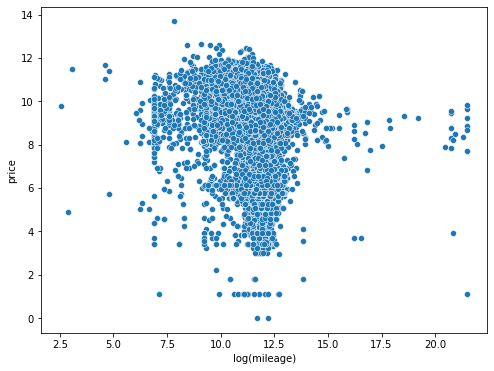

In [ ]:
logmileage = np.log(df['mileage'])
sns.scatterplot(x=logmileage, y=df['price']);
plt.xlabel('log(mileage)')

No clear trend is visible.

#### CYLINDERS

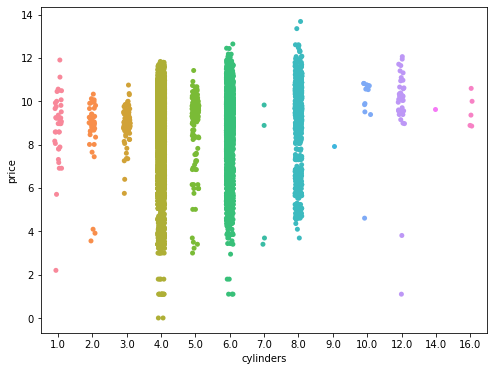

In [ ]:
sns.stripplot(data=df, x='cylinders', y='price');

4 to 8 cylinder cars are very common in the dataset. Cars with higher number of cylinders are costlier. Interestingly, cars in the dataset with 3 and lesser cylinders are also costly. This may be becausdue to other factors.

# GEAR

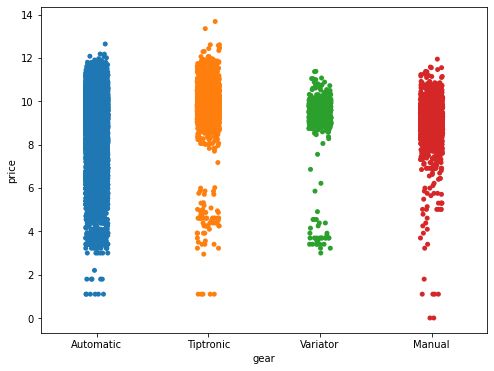

In [ ]:
sns.stripplot(data=df, x='gear', y='price');

No clear trend. Tiptronic and Variator prices are dense near the extreme ranges, sparse in the middle. Cheaper cars are more likely to be automatic than manual.

#### DRIVE

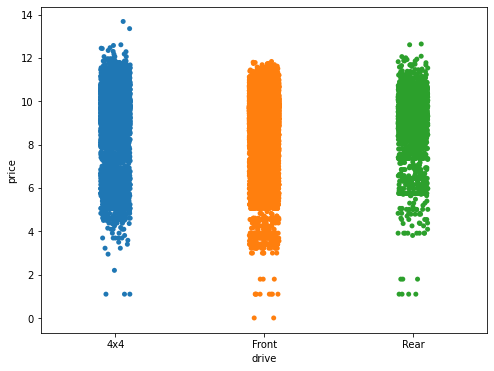

In [ ]:
sns.stripplot(data=df, x='drive', y='price')

Again, no clear trend.

#### WHEEL (steering wheel)

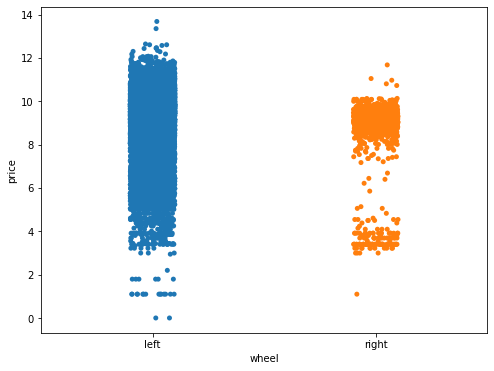

In [ ]:
sns.stripplot(data=df, x='wheel', y='price')

Distinct segments in prices of right-wheel cars. Costliest cars are left-sided (steering wheel).

#### COLOR

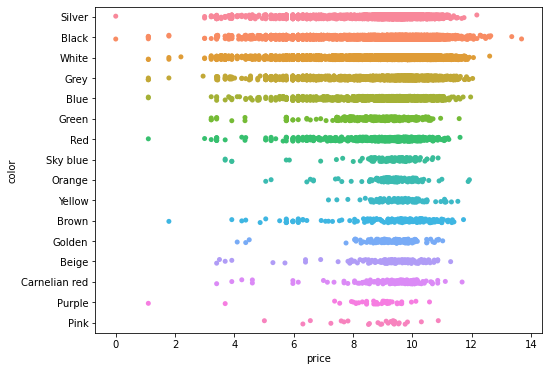

In [ ]:
sns.stripplot(data=df, y='color', x='price');

As expected, cheaper cars are more likely to be of common colors like Silver, White, etc. Unique colors like Yellow, Purple, Pink are expensive. Lets see if we find a Camaro in the yellow cars!

In [ ]:
df.loc[(df['color'] == 'Yellow')&(df['model'] == 'Camaro')].sort_values('price', ascending=False)[:10]

,price,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,turbo
13622,10.959992,1080.0,CHEVROLET,Camaro,2014,Cabriolet,1,Petrol,3.6,34481,4.0,Automatic,Front,4,left,Yellow,4,0
13743,10.784711,1307.0,CHEVROLET,Camaro,2015,Cabriolet,1,Petrol,3.6,99162,4.0,Automatic,Front,4,left,Yellow,4,0


As we thought!!

In [ ]:
# Let us save the file until now.
df.to_csv(root_path+'train_cleaned1.csv', index=False)
# df = pd.read_csv(root_path+'train_cleaned1.csv')
# dfc = df.copy()

### Some cars have extremely low price. Let us see if we can manually impute correct prices by inspection of similar cars.

In [ ]:
df.sort_values('price', ascending=True)[:5]

,price,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,turbo
7815,0.000000,NaN,OPEL,Astra,1999,Sedan,1,Petrol,1.6,122231,4.0,Manual,Front,4,left,Silver,4,0
16991,0.000000,1202.0,CHEVROLET,Lacetti,2006,Hatchback,0,Petrol,1.6,200000,4.0,Manual,Front,4,left,Black,2,0
13419,1.098612,503.0,TOYOTA,Prius C,2012,Hatchback,1,Petrol,1.5,172800,4.0,Automatic,Front,4,left,Grey,12,0
17595,1.098612,NaN,HYUNDAI,Sonata,2011,Sedan,1,Petrol,2.4,106422,4.0,Tiptronic,Front,4,left,White,6,0
7276,1.098612,NaN,MERCEDES-BENZ,G 55 AMG,2020,Jeep,1,LPG,1.8,1212,12.0,Manual,4x4,5,left,Purple,0,1


Let us look at other OPEL Astras of 1999.

In [ ]:
df.loc[(df['manufacturer'] == 'OPEL')
      & (df['model'] == 'Astra')
      & (df['prod'] == 1999)
      & (df['category'] == 'Sedan')
       & (df['engine'] == 1.6)
      ].sort_values('engine', ascending=False).sort_values('price'
                                                          )

,price,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,turbo
7815,0.000000,NaN,OPEL,Astra,1999,Sedan,1,Petrol,1.6,122231,4.0,Manual,Front,4,left,Silver,4,0
10815,8.455318,NaN,OPEL,Astra,1999,Sedan,0,Petrol,1.6,145000,4.0,Manual,Front,2,left,Green,2,0
12129,8.792701,NaN,OPEL,Astra,1999,Sedan,0,Petrol,1.6,227000,4.0,Manual,Front,4,left,Black,0,0


Let us impute the average of similar cars (having non-zero price).

In [ ]:
# imputing at index 7815
df.loc[7815, 'price'] = (8.455 + 8.793)/2.0

Chevrolet Lacetti 2006 hatchback.

In [ ]:
df.loc[(df['manufacturer'] == 'CHEVROLET')
      & (df['model'] == 'Lacetti')
      & (df['fuel'] == 'Petrol')
      # & (df['prod'] == 2006)
       & (df['engine'] == 1.6)
       & (df['mileage'] >= 200000)
      ].sort_values('price')

,price,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,turbo
16992,0.000000,1202.0,CHEVROLET,Lacetti,2006,Hatchback,0,Petrol,1.6,200000,4.0,Manual,Front,4,left,Black,2,0
7082,8.883640,NaN,CHEVROLET,Lacetti,2005,Sedan,0,Petrol,1.6,200000,4.0,Manual,Front,4,left,Silver,2,0
7587,9.190138,790.0,CHEVROLET,Lacetti,2009,Sedan,1,Petrol,1.6,219236,4.0,Automatic,Front,4,left,Black,4,0


In [ ]:
# imputing with average of similar cars
df.loc[16992, 'price'] = (8.884 + 9.190)/2.0

Index 13419, Toyota PRIUS C 2012

In [ ]:
df.loc[(df['manufacturer'] == 'TOYOTA')
      & (df['model'] == 'Prius C')
      & (df['prod'] == 2012)
      & (df['leather'] == 1)
      & (df['cylinders'] == 4)
      & (df['fuel'] == 'Petrol')
       & (df['engine'] == 1.5)
      ].sort_values('price')

,price,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,turbo
13419,1.098612,503.0,TOYOTA,Prius C,2012,Hatchback,1,Petrol,1.5,172800,4.0,Automatic,Front,4,left,Grey,12,0
6469,9.967682,NaN,TOYOTA,Prius C,2012,Hatchback,1,Petrol,1.5,162000,4.0,Automatic,Front,4,left,Silver,0,0
15478,10.065649,NaN,TOYOTA,Prius C,2012,Hatchback,1,Petrol,1.5,152000,4.0,Tiptronic,Front,4,left,White,8,0


In [ ]:
# imputing price based on mileage (guesstimate)
df.loc[13419,'price'] = 9.86

In [ ]:
df.sort_values('price', ascending=True)[:3]

,price,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,turbo
14492,1.098612,697.0,VOLKSWAGEN,Jetta,2015,Sedan,1,Petrol,1.8,65000,4.0,Automatic,Front,4,left,Grey,12,1
5890,1.098612,NaN,MERCEDES-BENZ,CLK 230,2004,Coupe,1,Petrol,2.3,328000,4.0,Manual,Rear,2,left,Blue,0,0
14642,1.098612,87.0,PORSCHE,Panamera,2011,Sedan,1,Petrol,0.0,196800,6.0,Automatic,Rear,4,left,Black,12,0


Volkswagen Jetta 2015 (index 14492)

In [ ]:
df.loc[(df['manufacturer'] == 'VOLKSWAGEN')
      & (df['model'] == 'Jetta')
      & (df['prod'] == 2015)
      & (df['leather'] == 1)
      & (df['cylinders'] == 4)
      & (df['gear'] == 'Automatic')
      & (df['fuel'] == 'Petrol')
       & (df['engine'] == 1.8)
      ].sort_values('price')

,price,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,turbo
14492,1.098612,697.0,VOLKSWAGEN,Jetta,2015,Sedan,1,Petrol,1.8,65000,4.0,Automatic,Front,4,left,Grey,12,1
2173,6.152733,697.0,VOLKSWAGEN,Jetta,2015,Sedan,1,Petrol,1.8,117006,4.0,Automatic,Front,4,left,White,12,0
12361,8.743851,697.0,VOLKSWAGEN,Jetta,2015,Sedan,1,Petrol,1.8,63792,4.0,Automatic,Front,4,left,Black,12,0
1188,9.554852,697.0,VOLKSWAGEN,Jetta,2015,Sedan,1,Petrol,1.8,45605,4.0,Automatic,Front,4,left,White,0,0
6109,9.755509,697.0,VOLKSWAGEN,Jetta,2015,Sedan,1,Petrol,1.8,70000,4.0,Automatic,Front,4,left,Silver,4,0
462,9.875294,NaN,VOLKSWAGEN,Jetta,2015,Sedan,1,Petrol,1.8,102400,4.0,Automatic,Front,4,left,Silver,8,1


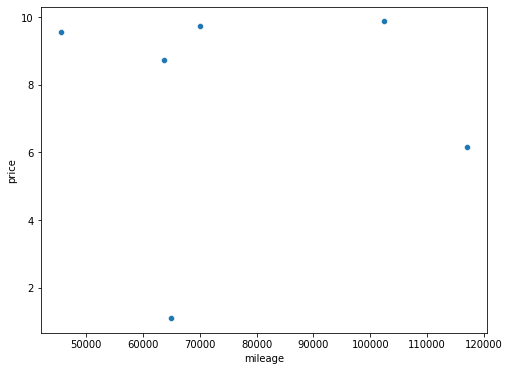

In [ ]:
# does the price relate linearly to mileage within a subset ?
sns.scatterplot(data=df.loc[(df['manufacturer'] == 'VOLKSWAGEN')
      & (df['model'] == 'Jetta')
      & (df['prod'] == 2015)
      & (df['leather'] == 1)
      & (df['cylinders'] == 4)
      & (df['gear'] == 'Automatic')
      & (df['fuel'] == 'Petrol')
       & (df['engine'] == 1.8)
      ].sort_values('price'), x='mileage', y='price')
# No it does not appear so..

In [ ]:
# imputing with the closes in terms of mileage and airbags (index 12361)
df.loc[14492, 'price'] = 8.3478

In [ ]:
# df.to_csv(root_path+'train_cleaned_manual1.csv', index=False)
df = pd.read_csv(root_path+'train_cleaned_manual1.csv')
dfc = df.copy()

### Model fitting and tuning

We will experiment with various hyperparams to find the least error, and log our progress as we go along.

In [ ]:
dfc.head()

,price,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,turbo
0,9.497622,1399.0,LEXUS,RX 450,2010,Jeep,1,Hybrid,3.5,186005,6.0,Automatic,4x4,4,left,Silver,12,0
1,9.718422,1018.0,CHEVROLET,Equinox,2011,Jeep,0,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,left,Black,8,0
2,9.043932,NaN,HONDA,FIT,2006,Hatchback,0,Petrol,1.3,200000,4.0,Variator,Front,4,right,Black,2,0
3,8.190632,862.0,FORD,Escape,2011,Jeep,1,Hybrid,2.5,168966,4.0,Automatic,4x4,4,left,White,0,0
4,9.369564,446.0,HONDA,FIT,2014,Hatchback,1,Petrol,1.3,91901,4.0,Automatic,Front,4,left,Silver,4,0


In [ ]:
df = dfc.copy()

# PREPARE TRAIN DATA

# target column
target_col = 'price'

df['levy_na']  = df['levy'].apply(lambda x: pd.isna(x))

df['prod'] = 2021 - df['prod']

imputer_strategy = 'mean'
encoder_strategy = 'onehot'

input_cols = list(df.drop(target_col , axis=1).columns)

print("len(input_cols)",len(input_cols))

numeric_cols = list(df[input_cols].select_dtypes(np.number).columns)
categorical_cols = list(df[input_cols].select_dtypes('object').columns)

print('num of numeric cols', len(numeric_cols))
print('num of category cols', len(categorical_cols))

# minmax scaling
minmax = MinMaxScaler()
df[numeric_cols] = minmax.fit_transform(df[numeric_cols])

# categorical imputation
if encoder_strategy == 'onehot':
  encoder = OneHotEncoder(sparse=False, handle_unknown = 'ignore')    
  encoder.fit(df[categorical_cols])
  encoded_cols = list(encoder.get_feature_names(categorical_cols))
  df[encoded_cols] = encoder.transform(df[categorical_cols])

print('num encoded cols', len(encoded_cols))
training_cols = numeric_cols+encoded_cols # very important

# splitting into train and validation
train_inputs, val_inputs, train_targets, val_targets = train_test_split(df[training_cols],
                                                                      df[target_col],
                                                                      test_size=0.3,
                                                                      random_state=21)


# NUMERIC IMPUTATION
imputer_strategy = 'mean' # KNN

imputer = SimpleImputer(strategy=imputer_strategy)
imputer.fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])

# getting final train and val data
x_train = train_inputs[numeric_cols+encoded_cols]
x_val = val_inputs[numeric_cols+encoded_cols]

x_train.shape, x_val.shape, train_targets.shape, val_targets.shape

len(input_cols) 18
num of numeric cols 9
num of category cols 8
num encoded cols 1698


((13465, 1707), (5771, 1707), (13465,), (5771,))

In [ ]:
# FUNCTION TO FIT MODEL, GET TRAIN AND VALIDATION ERROR AND SAVE METRICS
def fit_predict(estimator, remarks = '', x_train=x_train, train_targets=train_targets, x_val=x_val, 
                val_targets=val_targets):
    print(datetime.now())
    estimator.fit(x_train, train_targets)
    train_preds = estimator.predict(x_train)
    val_preds = estimator.predict(x_val)

    from sklearn.metrics import mean_squared_error
    
    train_error = np.sqrt(mean_squared_error(train_targets, train_preds))
    val_error = np.sqrt(mean_squared_error(val_targets, val_preds))
    
    # PRINTING METRICS
    print('Train RMSLE:', train_error)
    print('Val RMSLE:', val_error)
    
    # LOGGING MODELLING PARAMS - saving  in google drive (let me know if you want to see the file)
    
    log = pd.read_excel(root_path+'model_params_metrics.xlsx')
    
    size= len(log.index)
    log.loc[size] = np.nan
    log.loc[size, 'Date'] = datetime.now()
    log.loc[size,'estimator'] = str(estimator)
    log.loc[size,'hyperparams'] = str(estimator.get_params())[1:-1]
    log.loc[size, 'train_RMSLE'] = train_error
    log.loc[size, 'val_RMSLE'] = val_error
    log.loc[size, 'Outlier technique'] = remarks
    
    dfimp = pd.DataFrame({'Column':x_train.columns, 'Imp': model.feature_importances_}).reset_index(
        drop=True).set_index('Column').sort_values('Imp',ascending=False)
    
    # identifying 20 most important columns in prediction
    log.loc[size, '20 mostimp cols'] = str(dict(zip(dfimp.index[:20], dfimp['Imp'][:20].values)))
    
    log.to_excel('model_params_metrics.xlsx', index=False)
    log.tail()

### We will fit using RandomForest model, as they are known to be robust outliers, and useful in a wide range of applications.

In [ ]:
model = RandomForestRegressor(random_state=21, max_depth=30)
fit_predict(model)

2021-07-21 14:21:29.098248
Train RMSLE: 0.4023754691643431
Val RMSLE: 0.9456922580313588


In [ ]:
model = RandomForestRegressor(random_state=21, max_leaf_nodes=250, n_estimators = 50)
fit_predict(model)

2021-07-21 15:23:00.490941
Train RMSLE: 0.803599181954693
Val RMSLE: 1.0173191678562346


#### Trying to introduce more randomness in the model..

In [ ]:
model = RandomForestRegressor(random_state=21, max_samples=3000, n_estimators=50, bootstrap=False)
fit_predict(model, remarks = 'trying with reduced max_samples and bootstrap false')

2021-07-21 14:36:57.661324
Train RMSLE: 0.17877867046820525
Val RMSLE: 1.174641883294352


In [ ]:
model = RandomForestRegressor(random_state=21, max_samples=3000, n_estimators=50,max_depth = 20, bootstrap=False)
fit_predict(model, remarks='trying with reduced max_samples and bootstrap false, reduced max_depth')

2021-07-21 14:40:17.097964
Train RMSLE: 0.5005945612683508
Val RMSLE: 1.1426015112842933


NOTE: I tried to tune using GridSearchCV, but it took very long time. Hence, proceeding with manual tuning.

In [ ]:
model = RandomForestRegressor(random_state=21, max_samples=2000, n_estimators=80,max_features='sqrt')
fit_predict(model, 'bootstrap false, reduced max_features')

2021-07-21 14:41:42.267372
Train RMSLE: 0.9140633501937947
Val RMSLE: 1.0456095222945672


In [ ]:
model = RandomForestRegressor(random_state=21, max_samples=0.5, n_estimators=150, max_depth = 50, max_features='sqrt')
fit_predict(model, 'reduced max_features and max_samples')

2021-07-21 14:43:00.464958
Train RMSLE: 0.6287584604211284
Val RMSLE: 0.9558156705500942


#### Let us take a look at the most important columns. Fit again using the earlier, less regularised model, and visualise feature importances.

2021-07-21 14:44:35.306065
Train RMSLE: 0.803599181954693
Val RMSLE: 1.0173191678562346


<Figure size 648x1224 with 0 Axes>

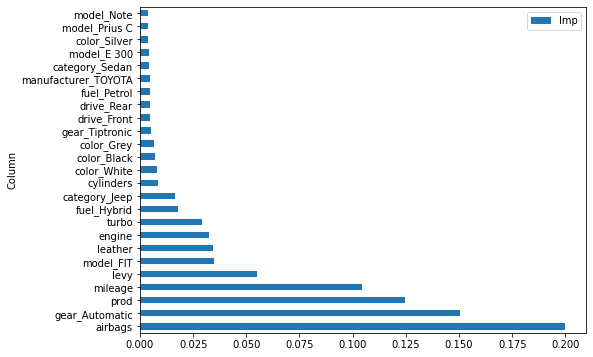

In [ ]:
model = RandomForestRegressor(random_state=21, max_leaf_nodes=250, n_estimators = 50)
fit_predict(model)

dfimp = pd.DataFrame({'Column':x_train.columns, 'Imp': model.feature_importances_}).reset_index(
    drop=True).set_index('Column').sort_values('Imp',ascending=False)
plt.figure(figsize=(9,17))
dfimp[:25].plot(kind='barh') # visualise 25 most important columns

In [ ]:
imp_cols = list(dfimp[:25].index)
xt = x_train[list(dfimp[:25].index)]
xv = x_val[list(dfimp[:25].index)]
model = RandomForestRegressor(random_state=21, n_estimators=120, max_leaf_nodes = 250, max_features=0.6)
fit_predict(model, x_train=xt, x_val=xv, remarks = 'imp cols')

2021-07-21 15:03:22.502925
Train RMSLE: 0.8440845692375338
Val RMSLE: 1.007361785573353


#### Let us try with XGB, as it is known to provide very good performance.

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror',max_depth=4,learning_rate=0.3, random_state=21)


xt = x_train[imp_cols].sample(10000,replace=False)
xv = x_val[imp_cols]
new_targets = train_targets.loc[xt.index]

xgb.fit(xt.values, new_targets.values)
xgb_preds = xgb.predict(xv.values)
print('XGB train RMSLE',np.sqrt(mean_squared_error(new_targets, xgb.predict(xt.values))))
print('XGB val RMSLE', np.sqrt(mean_squared_error(val_targets, xgb.predict(xv.values))))

XGB train RMSLE 0.92042490278277
XGB val RMSLE 1.059655164691844


In [ ]:
# increased max_depth in XGB
xgb = XGBRegressor(objective='reg:squarederror',max_depth=5,learning_rate=0.2, random_state=21)

xt = x_train[imp_cols].sample(10000,replace=False)
xv = x_val[imp_cols]
new_targets = train_targets.loc[xt.index]

xgb.fit(xt.values, new_targets.values)
xgb_preds = xgb.predict(xv.values)
print('XGB train RMSLE',np.sqrt(mean_squared_error(new_targets, xgb.predict(xt.values))))
print('XGB val RMSLE', np.sqrt(mean_squared_error(val_targets, xgb.predict(xv.values))))
# slight improvement in performance

XGB train RMSLE 0.8477464734468451
XGB val RMSLE 1.0364958333484808


Let us now aggregate the predictions of RandomForest and XGB

In [ ]:
xgb = XGBRegressor(objective='reg:squarederror',max_depth=4,learning_rate=0.3, random_state=21)
model = RandomForestRegressor(random_state=21, n_estimators=120, max_leaf_nodes = 230, max_features=0.6)

imp_cols = list(dfimp[:25].index)
xt = x_train[imp_cols].sample(10000,replace=False)
xv = x_val[imp_cols]
new_targets = train_targets.loc[xt.index]

xgb.fit(xt.values, new_targets.values)
xgb_preds = xgb.predict(xv.values)
print('XGB train RMSLE',np.sqrt(mean_squared_error(new_targets, xgb.predict(xt.values))))
print('XGB val RMSLE', np.sqrt(mean_squared_error(val_targets, xgb.predict(xv.values))))

xt = x_train[imp_cols].sample(8000,replace=False)
xv = x_val[imp_cols]
new_targets = train_targets.loc[xt.index]

model.fit(xt.values, new_targets.values)
rf_preds = model.predict(xv.values)
print('RF train RMSLE',np.sqrt(mean_squared_error(new_targets, model.predict(xt.values))))
print('RF val RMSLE', np.sqrt(mean_squared_error(val_targets, model.predict(xv.values))))

avg_preds = (rf_preds + xgb_preds)/2.0
print('aggregated val score', np.sqrt(mean_squared_error(val_targets, avg_preds)))

XGB train RMSLE 0.916578511976817
XGB val RMSLE 1.0553385730883853
RF train RMSLE 0.7835966077951172
RF val RMSLE 1.0371810099154575
aggregated val score 1.0270716505867026


The validation score is close to the best we have got using only RF. So, not much improvement in performance.

In [ ]:
log = pd.read_excel(root_path+'model_params_metrics.xlsx') # let me know if you need complete file
log.sort_values('val_RMSLE')[:3] # if train and val error are close, it means less overfitting

,Date,Outlier rows dropped,Outlier technique,Levy or log levy,Train-duplicates dropped,Col for prediction (price/logprice),Numeric Imputation,Categorical Imputation,Split ratio,machicnehack test set used for categorical imputaton,estimator,hyperparams,train_RMSLE,val_RMSLE,test_RMSLE,20 mostimp cols
6,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RFRegressor,"random_state=21, max_depth=60",0.390000,0.964000,NaN,NaN
5,2021-07-09 00:00:00.000,0,NaN,levy,0,logprice,Median,Not required,70:30,NO,RFRegressor,"random_state=21, max_depth=35,",0.394000,0.965000,NaN,NaN
9,2021-07-09 23:46:49.474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"RandomForestRegressor(max_depth=20, min_sample...","'bootstrap': True, 'ccp_alpha': 0.0, 'criterio...",0.709734,0.984271,NaN,NaN


### Final prediction and submission on test data.

In [ ]:
# best RF performance yet
model = RandomForestRegressor(random_state=21, max_leaf_nodes=250, n_estimators = 50)
fit_predict(model)

2021-07-21 15:20:56.755134
Train RMSLE: 0.8440845692375338
Val RMSLE: 1.007361785573353


In [ ]:
dftest = pd.read_csv(root_path+'test.csv')
dftest = carprice_preprocess(dftest, istest=True)
dftest.head(2)

,levy,manufacturer,model,prod,category,leather,fuel,engine,mileage,cylinders,gear,drive,doors,wheel,color,airbags,price,turbo
0,NaN,VOLKSWAGEN,Golf,2012,Hatchback,0,Diesel,2.0,0,4,Manual,Front,2,left,Grey,10,NaN,1
1,NaN,HYUNDAI,Sonata,2012,Sedan,1,Petrol,2.4,26000,4,Tiptronic,Front,4,left,Grey,10,NaN,0


In [ ]:
# PREPARE TEST DATA
test_inputs = dftest.drop('price', axis=1)
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])
test_inputs[numeric_cols] = minmax.transform(test_inputs[numeric_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])
test_inputs = test_inputs[training_cols]

# SUBMISSION FILE
test_preds = model.predict(test_inputs.values)
test_preds = np.exp(test_preds)
dfsubmit = pd.DataFrame(test_preds, columns = ['Price'])
submit_file = str(datetime.now().strftime("%Y-%m-%d %H:%M:%S")).replace(' ','_') + '.csv'
submit_file = submit_file.replace(':','_')
print(submit_file)
submit_path= 'C:\\Users\\Anshu\\Data Science\\TheMathCompany-hackathon\\submissions\\'
dfsubmit.to_csv(submit_path + submit_file, index=False)
print('Submission file saved')

2021-07-21_15_25_52.csv
Submission file saved


### Thanks!

Thanks for going through my work!

In this notebook, I have mentioned the major steps in cleaning, preprocesing and model fitting on carprice dataset. Detailed notebooks and rough work for EDA and other analysis that I tried (some of which did not help), can be found on github.

Github:   https://github.com/antariksh0094

Jovian :  https://jovian.ai/antariksh0094


Would love feedback/suggestions!

LinkedIn: https://www.linkedin.com/in/antariksh-anupam-2b3a7673/

Email ID: antariksh.0094@gmail.com